# Get the latest node list from Bitnodes API

In [ ]:
# import requests
import requests

In [ ]:
headers = {'Accept': 'application/json; indent=4',}
bitnodes_data = requests.get('https://bitnodes.earn.com/api/v1/snapshots/latest/', headers=headers)

# Convert Bitnodes API output to CSV

In [ ]:
# import pandas
import pandas as pd

In [ ]:
# read the JSON into a DataFrame
bitnodes = pd.read_json(bitnodes_data.text)
bitnodes.head()

In [ ]:
# examine how many records (e.g., mining nodes)
len(bitnodes)

In [ ]:
# looking at the above DataFrame, we are interested in the 'nodes' field
bitnodes.nodes[1]

In [ ]:
# node list fields have these names:
# 'Protocol version', 'User agent', 'Connected since', 'Services', 'Height', 'Hostname', 'City', 'Country code', 'LAT', 'LON', 'Timezone', 'ASN', 'Organization name'
# create a nodes column list
node_fields = ['Protocol_version', 'User_agent', 'Connected_since', 'Services', 'Height', 'Hostname', 'City', 'Country_code', 'LAT', 'LON', 'Timezone', 'ASN', 'Organization_name']

# create a new dataframe from the 'nodes' list field above with the column names
bitnodes_nodes = pd.DataFrame(bitnodes.nodes.values.tolist(), columns=node_fields)
bitnodes_nodes.head()

In [ ]:
# convert the Unix timestamp to YYYY-DD-MM hh:mm:ss format
bitnodes_nodes['Connected_since'] = pd.to_datetime(bitnodes_nodes['Connected_since'], unit='s')
bitnodes_nodes.head()

In [ ]:
# check to make sure we have the same number of records
len(bitnodes_nodes) == len(bitnodes)

In [ ]:
# save the new nodes DataFrame as a CSV
bitnodes_nodes.to_csv('data/bitnodes.csv', encoding='utf-8')

### Mapping US-based nodes

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import mapping
import shapely.speedups # does this help?
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# import states and nodes data
states = gpd.read_file('http://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_20m.zip')
nodes = pd.read_csv('data/bitnodes.csv')

In [3]:
states.crs

{'init': 'epsg:4269'}

In [4]:
# create a GeoDataFrame from the CSV data and use the NAD 83 epsg:4269 CRS
geoms = [Point(xy) for xy in zip(nodes.LON, nodes.LAT)]
crs = {'init' :'epsg:4326'}
nodes_geo = gpd.GeoDataFrame(nodes, crs=crs, geometry=geoms)

In [5]:
# create clip layer for US
states_poly = states.geometry.unary_union

In [6]:
# clip points to US
nodes_conus = nodes_geo[nodes_geo.geometry.intersects(states_poly)]

In [7]:
# reproject into NAD83
states_eqdc = states.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
nodes_eqdc = nodes_conus.to_crs('+proj=eqdc +lat_0=39 +lon_0=-96 +lat_1=33 +lat_2=45 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')

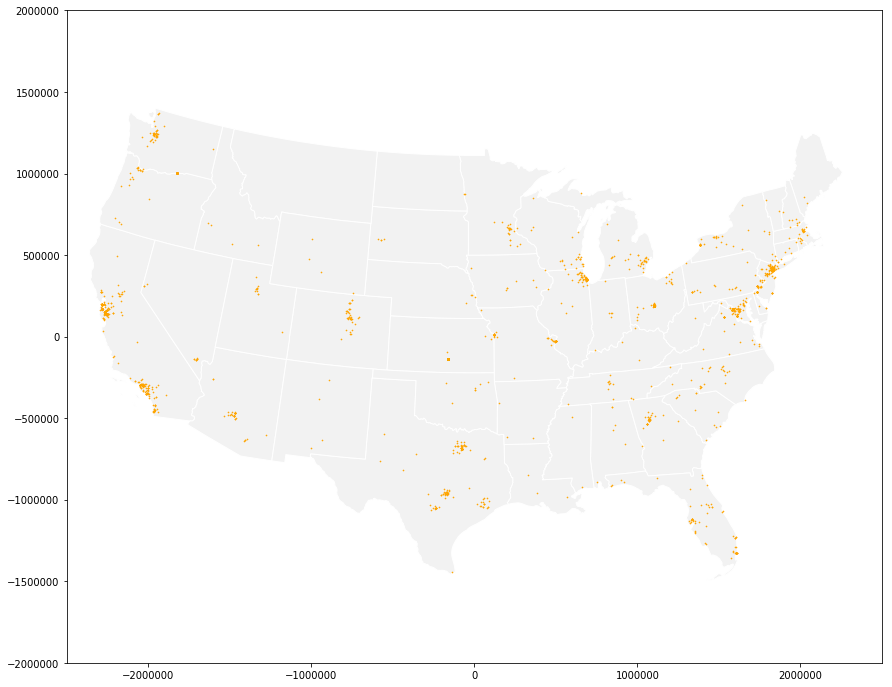

In [8]:
# plot the data to have a look
fig, ax = plt.subplots(figsize=(15, 12))

states_eqdc.plot(ax=ax, edgecolor='white', color='#f2f2f2', zorder=0);
nodes_eqdc.plot(ax=ax, color='orange', zorder=1, markersize=.4);

ax.set(xlim=(-2500000,2500000), ylim=(-2000000,2000000));